# HW 2 Compsem
Добрынина Анастасия, БКЛ-211

In [1]:
import sys
import wget
import zipfile
import gensim, logging
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
with open("HW2_igrat'.txt", 'r', encoding='utf-8') as file:

    igrat_file = pd.read_csv(file, names = ['nouns', 'count'], sep = '\t')

In [3]:
igrat_file

,nouns,count
0,играть_роль,3121
1,играть_музыка,614
2,играть_ребенок,335
3,играть_оркестр,331
4,играть_актер,238
...,...,...
108,играть_утро,20
109,играть_слово,20
110,играть_мольер,20
111,играть_солдат,20


In [4]:
nouns = [n.split('_')[1] + '_NOUN' for n in list(igrat_file['nouns'])]

In [5]:
nouns[:10]

['роль_NOUN',
 'музыка_NOUN',
 'ребенок_NOUN',
 'оркестр_NOUN',
 'актер_NOUN',
 'человек_NOUN',
 'время_NOUN',
 'карта_NOUN',
 'музыкант_NOUN',
 'солнце_NOUN']

# 1, 2
1. Взять любую предобученную векторную модель для русского языка и извлечь оттуда вектор для глагола и каждого существительного из списка.

2. На основе этих векторов построить репрезентацию для каждой пары «глагол + существительное» с помощью простой аддитивной модели композиции.

Примечание. Если каждый вектор – это объект типа array в модуле numpy, то можно просто сложить эти два объекта, используя оператор «+».

In [6]:
model_url = 'http://vectors.nlpl.eu/repository/20/180.zip' # нкря

In [7]:
#model_url = 'http://vectors.nlpl.eu/repository/20/65.zip'

In [8]:
%%time
m = wget.download(model_url)
model_file = model_url.split('/')[-1]

CPU times: total: 5.92 s
Wall time: 1min 28s


In [9]:
%%time
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

2024-02-14 11:56:47,262 : INFO : loading projection weights from <zipfile.ZipExtFile name='model.bin' mode='r' compress_type=deflate>
2024-02-14 11:56:51,676 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (189193, 300) matrix of type float32 from <zipfile.ZipExtFile [closed]>', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-02-14T11:56:51.676302', 'gensim': '4.3.0', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'load_word2vec_format'}


CPU times: total: 3.7 s
Wall time: 4.42 s


In [10]:
# тест, что все работает
model.most_similar(positive=["слон_NOUN", "океан_NOUN"], negative=["африка_PROPN"], topn=1)

[('черепаха_NOUN', 0.44083723425865173)]

In [11]:
verb_vec = model.get_vector('играть_VERB')
matrix = [] # сюда соберем все векторы пар
noun2vec = {}
for noun in nouns:
    try:
        matrix.append(verb_vec + model.get_vector(noun))
        noun2vec[noun] = verb_vec + model.get_vector(noun)
    except:
        matrix.append(verb_vec + model.get_vector(noun.split('_')[0] + '_PROPN')) #спартак и шопен
        noun2vec[noun] = verb_vec + model.get_vector(noun.split('_')[0] + '_PROPN')

Сохраняю словарь соответствия вектора пары глагол+существительное и самого существительного, чтобы потом можно было однозначно восстановить, какое существительное было закодировано. Метод most_similar не смог бы однозначно восстановить слово/словосочетание по сложенному эмбеддингу

In [12]:
noun2vec['роль_NOUN']

array([-3.97780800e+00, -1.43540370e+00, -1.70213485e+00,  3.36860633e+00,
        1.30896997e+00, -2.78716588e+00,  5.53089499e-01,  1.56213176e+00,
       -1.22634172e+00, -3.40972245e-01, -2.87366891e+00,  2.37343574e+00,
        5.66228199e+00, -3.29585719e+00,  2.72316122e+00, -5.90874386e+00,
       -1.83591545e+00,  5.83753777e+00, -4.03708744e+00,  2.89649487e+00,
        1.54924035e+00,  1.39148378e+00,  3.70739412e+00,  5.31472158e+00,
        1.28375626e+00,  4.60313225e+00,  2.35380197e+00,  2.32740426e+00,
       -2.63639212e+00,  2.01716042e+00, -4.64474726e+00, -3.44575143e+00,
        2.00884151e+00, -2.15795517e+00, -2.61932659e+00,  1.04624510e+00,
       -1.05226684e+00, -5.38209105e+00,  5.07652521e+00, -1.20284450e+00,
       -2.13267565e+00, -1.03486574e+00,  4.61874962e-01,  2.26383209e+00,
       -3.47245765e+00,  8.63643646e-01,  3.11479759e+00,  4.62444276e-01,
        1.03641629e+00, -6.94586396e-01, -4.13077688e+00,  8.97645950e-04,
        2.73323107e+00, -

In [13]:
X = np.array(matrix)
print (X.shape)

(113, 300)


Есть 113 слов, закодированных по 300 измерений

# 3 
Собрать все векторные представления пар в единую матрицу и кластеризовать их двумя способами:
- методом иерархической кластеризации;
- методом К-средних, см. хендаут.

## Иерархическая кластеризация

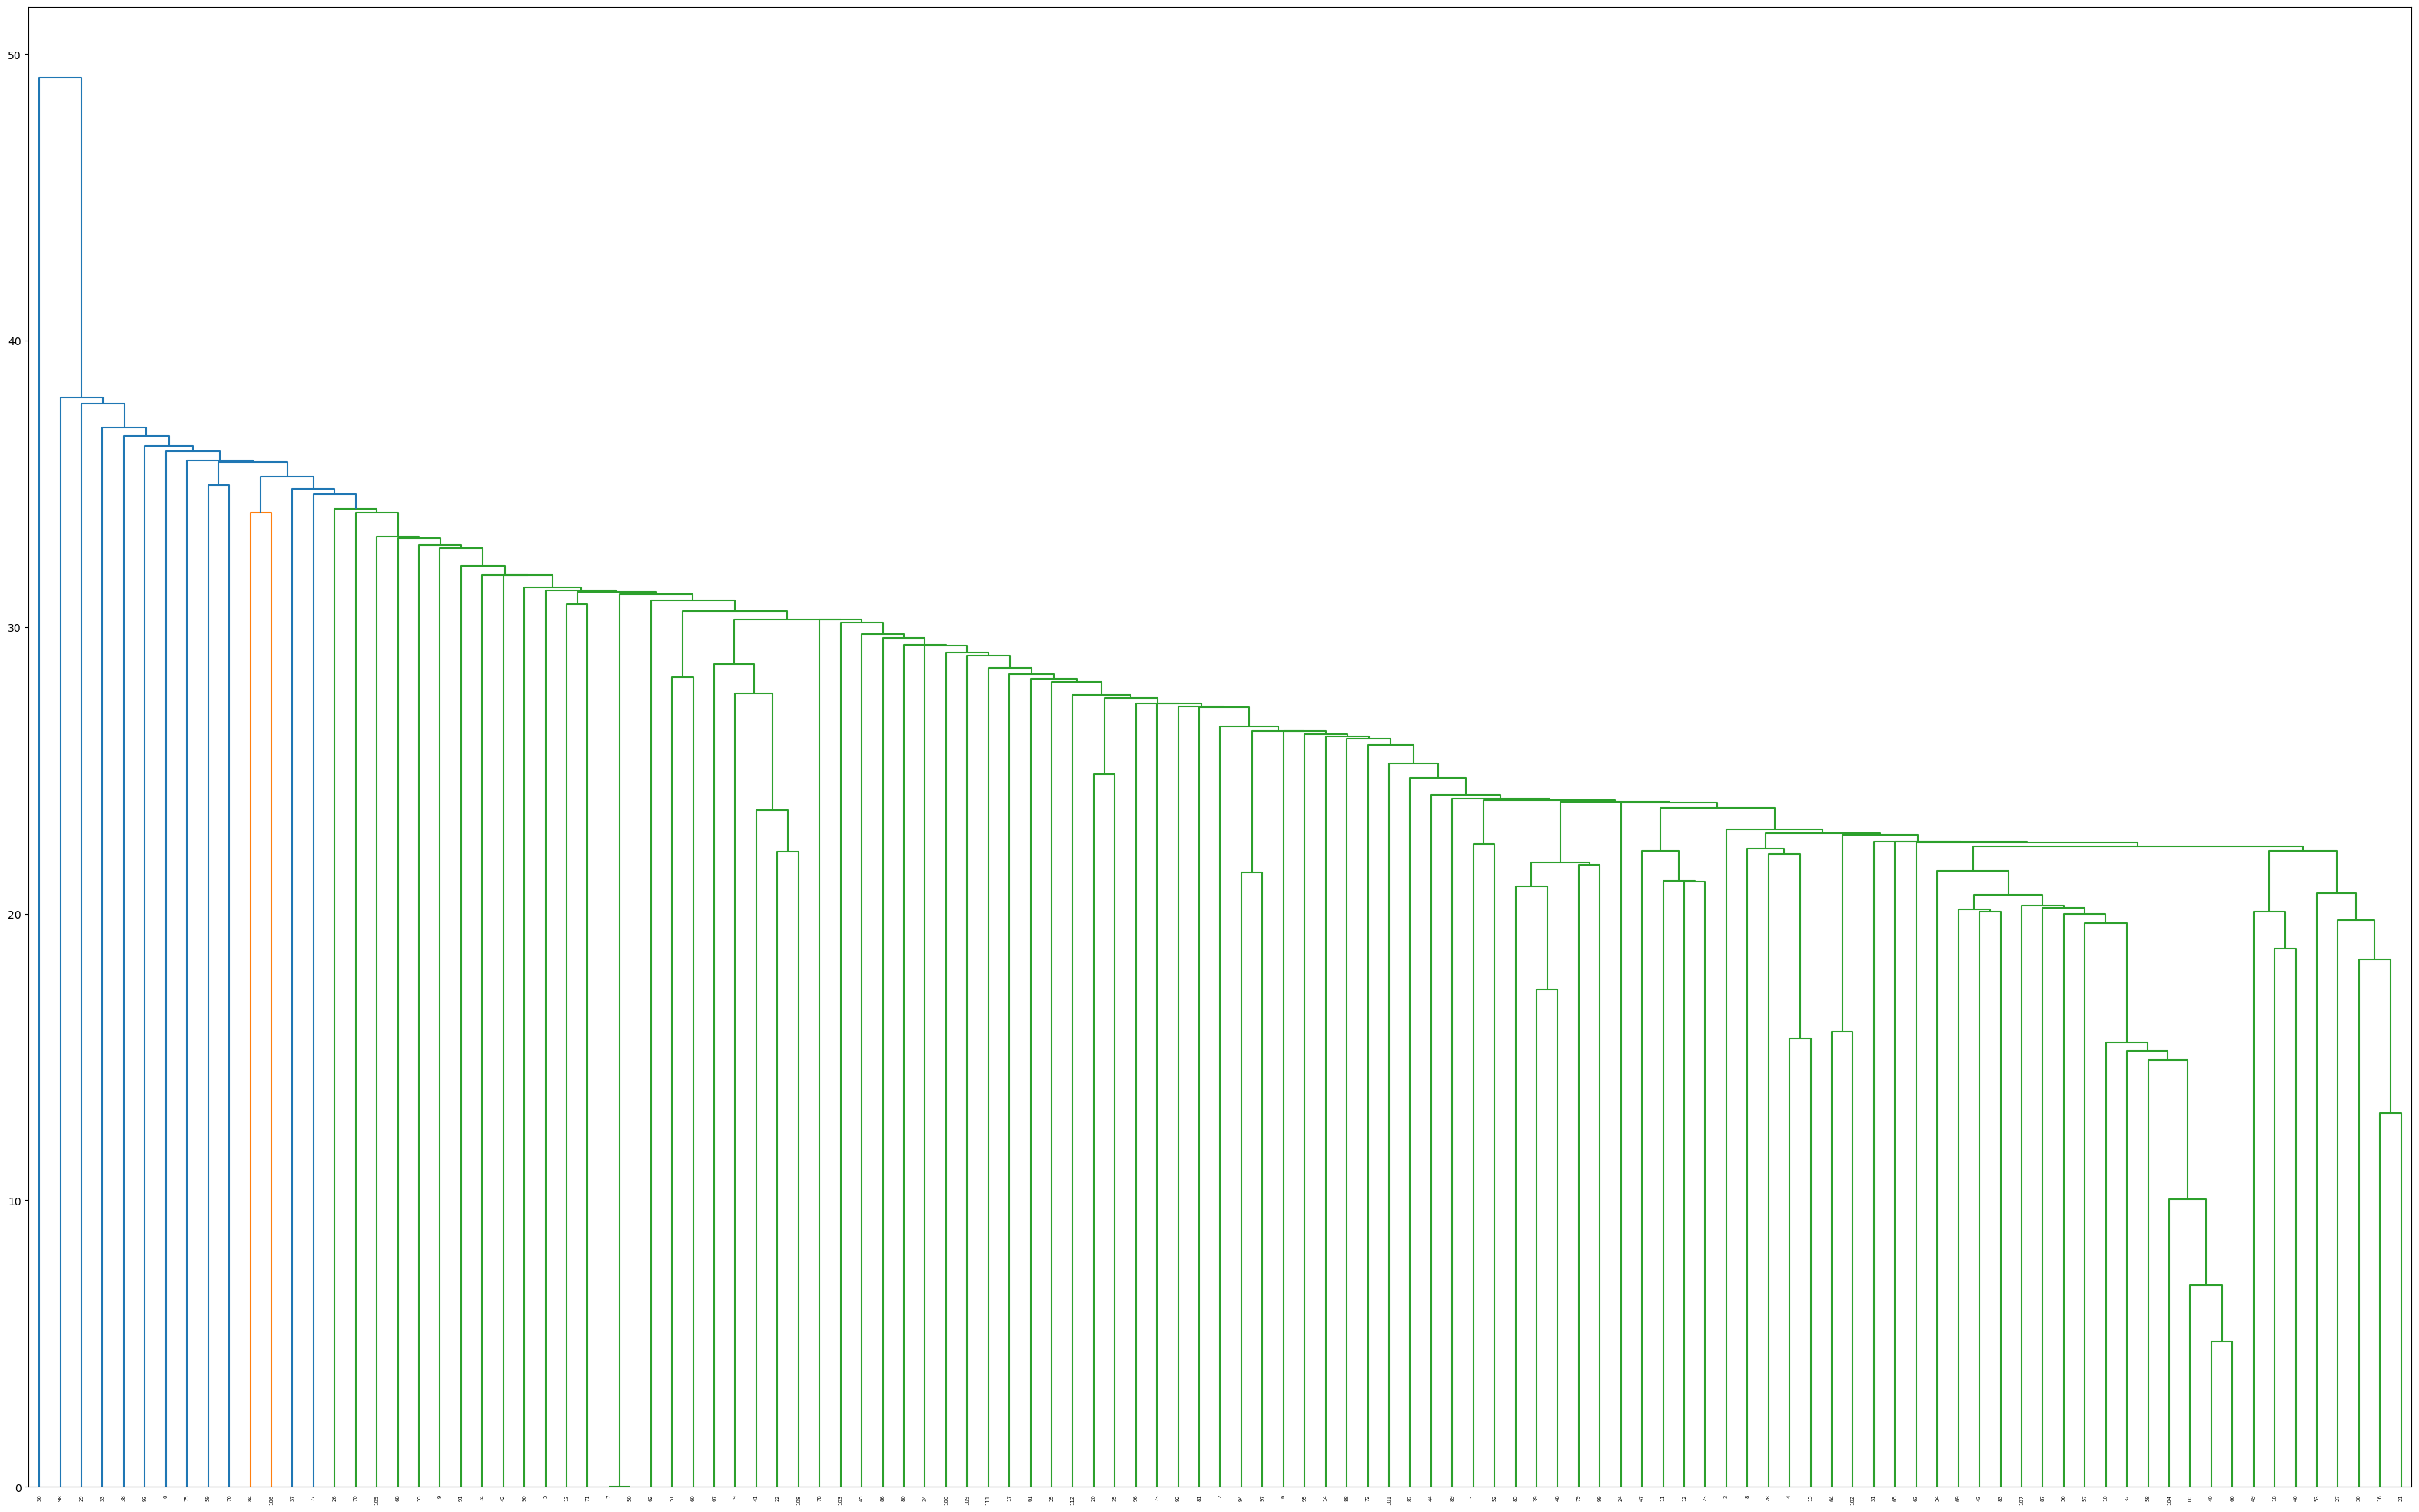

In [14]:
Z = hcluster.linkage(X)
plt.figure(figsize=(40, 25))
dn = hcluster.dendrogram(Z)
plt.show()

In [15]:
clusters = hcluster.fcluster(Z, 1)
print('Estimated number of clusters: %d' % len(set(clusters)))

Estimated number of clusters: 72


In [16]:
clusters_test = hcluster.fcluster(Z, 1.1)
print('Estimated number of clusters: %d' % len(set(clusters_test)))

Estimated number of clusters: 71


In [17]:
clusters_test = hcluster.fcluster(Z, 1.2)
print('Estimated number of clusters: %d' % len(set(clusters_test)))

Estimated number of clusters: 1


In [18]:
clusters_test = hcluster.fcluster(Z, 0.7)
print('Estimated number of clusters: %d' % len(set(clusters_test)))

Estimated number of clusters: 95


При пороге больше 1.1 все объединяется в один кластер. При пороге меньше 0.7 выделяется 95 кластеров, что довольно много для 113 элементов (то есть, почти все элементы выделяются в собственный кластер). Остановимся на пороге равном 1, выделим 72 кластера

In [19]:
print(clusters)

[66  9 33 22 12 52 32  4 12 57 15 11 11  3 30 12 18 41 17  6  7 18  6 11
 23 39 62 18 12 70 18 21 15 69 45  7 72 64 68 10 15  6 54 14 25 48 17 11
 10 17  4  5  9 18 16 58 15 15 15  1  5 40 51 19 13 20 15  6 59 14 61  3
 28 36 55 65  1 63 50 10 46 34 26 14  2 10 47 15 29 24 53 56 35 67  8 31
 37  8 71 10 44 27 13 49 15 60  2 15  6 43 15 42 38]


# 4, 5
4. Для каждого кластера определите центр и выберите по три элемента, наиболее к нему близких (по метрике косинусной близости). Центр можно определить как среднее арифметическое среди всех элементов кластера по каждому измерению (например, с помощью метода numpy.mean). Кластеры, размер которых не превышает двух элементов, не учитывайте совсем.
5. Оформите результат в виде набора групп из трех словосочетаний, например:

In [20]:
# делает соответсвие кластеров и самих векторов
def mapping(X, clusters):
    mapping = [[] for i in range(len(set(clusters)))] # на i-той позиции лежит список векторов, входящих в i+1 -й кластер
    for vec, c in zip(X, clusters):
        mapping[c-1].append(vec)   
    return mapping

In [21]:
# берет матрицу косинусной схожести, в которой последний вектор - центральный, 
# ищет 3 похожих на него вектора, возвращает их векторы
def find_three_similar_idx(cos_sim):
    center_similarity = list(cos_sim[-1])[:-1]
    values = sorted(center_similarity, reverse = True)[0:3]
    return [center_similarity.index(values[0]), 
            center_similarity.index(values[1]), 
            center_similarity.index(values[2])]

In [22]:
# находит центральный вектор по всем измерениям, добавляет его в кластер, 
# по векторам из предыдущей функции достает из словаря существительные
def get_clusters_words(mapping):
    cluster_words = [] 
    for c in mapping:
        if len(c) > 2:
            center = []
            for idx in range(300):
                center.append(np.mean([vec[idx] for vec in c])) # центральный вектор кластера
            c.append(center)
            sim = cosine_similarity(c)
            res = find_three_similar_idx(sim)
            cluster_words.append([get_noun(c[res[0]]), get_noun(c[res[1]]), get_noun(c[res[2]])])
    return cluster_words
        

In [23]:
# достает из словаря существительное пое вектору
def get_noun(vec):
    for k, v in noun2vec.items():
        if list(v) == list(vec):
            return k.split('_')[0]
    

In [24]:
# красиво печатает словосочетания
def represent(cluster_words):
    for cluster in cluster_words:
        print('играть_' + cluster[0] + ', ' + 'играть_' + cluster[1] + ', ' + 'играть_' + cluster[2])

In [25]:
represent(get_clusters_words(mapping(X, clusters)))

играть_вечер, играть_утро, играть_день
играть_отец, играть_мать, играть_дочь
играть_пьеса, играть_спектакль, играть_комедия
играть_артист, играть_актер, играть_актриса
играть_футбол, играть_теннис, играть_спартак
играть_моцарт, играть_россия, играть_молчанка
играть_женщина, играть_мужчина, играть_девушка
играть_мальчишка, играть_мальчик, играть_девочка


### Вывод

Выделяются значения: 
- постановка произведения в театре
- актерская игра
- игра в спортивные игры
    - но здесь смешаны сами игры и название команды
- игра как род человеческой деятельности
    - отдельно выделяются термины родства, обозначения взрослых и детей
    
Кластер с обозначением врмеени суток, видимо выделяется из-за сочетаний *играть весь день/утро/вечер*, что по сути ничего не говорит о значении глагола.

Самая неконсистентная группа: моцарт, россия, молчанка.

Нет некоторых значений, которые можно было бы ожидать: игра на музыкальных инструментах, различные метафорические значения

# K-средних

Попробудем выделить столько же кластеров, как и в иерерхической кластеризации

In [26]:
kmeans = KMeans(n_clusters=72).fit(X)
label = kmeans.labels_
label

C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([12,  8, 69,  1, 43, 44, 70, 17,  1, 45,  9, 13, 54, 52, 57, 43, 34,
       47,  2, 26, 29, 34,  4, 54,  8, 63, 38,  0, 43, 35,  0, 59,  9, 27,
       60, 29, 14, 36, 28,  3,  9,  4, 24,  6, 13, 50,  2, 13,  3,  2, 17,
       67,  8,  0, 61, 30, 61,  9,  9, 11, 19, 65, 53, 34, 39,  9,  9, 55,
       48, 59, 22, 10, 13, 58, 32, 21, 20, 31,  5,  3,  7, 64, 43,  6, 37,
        3, 62, 61, 71, 51, 42, 25, 49, 23, 33, 68,  6, 33, 16,  3, 41, 54,
       39, 40,  9, 15, 18, 61,  4, 66,  9, 56, 46])

In [27]:
represent(get_clusters_words(mapping(X, kmeans.labels_)))

играть_женщина, играть_мужчина, играть_девушка
играть_отец, играть_мать, играть_дочь
играть_вечер, играть_утро, играть_ночь
играть_спартак, играть_футбол, играть_матч
играть_музыка, играть_джаз, играть_вальс
играть_моцарт, играть_россия, играть_мольер
играть_спектакль, играть_театр, играть_сцена
играть_девочка, играть_мальчик, играть_мама
играть_актер, играть_артист, играть_актриса
играть_комедия, играть_пьеса, играть_трагедия
играть_шарманка, играть_гармонь, играть_скрипка
играть_мальчишка, играть_ребятишки, играть_ребята


Заметим, что результаты другие. Выделяется больше кластеров (т.е. они не изчезают после фильтрации по ограничению на 2 элемента). Есть новый осмысленный кластер: игра на музыкальных инструментах. Как ив предыдущей кластеризации, отдельно выделяется актерская игра

Попробуем сделать больше кластеров

In [28]:
kmeans = KMeans(n_clusters=110).fit(X)
label = kmeans.labels_

C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [29]:
represent(get_clusters_words(mapping(X, kmeans.labels_)))

играть_моцарт, играть_россия, играть_мольер


Выделяется всего один кластер. Возьмем меньше кластеров

In [30]:
kmeans = KMeans(n_clusters=50).fit(X)
label = kmeans.labels_

C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [31]:
represent(get_clusters_words(mapping(X, kmeans.labels_)))

играть_футбол, играть_теннис, играть_шахматы
играть_шарманка, играть_скрипка, играть_гармонь
играть_актер, играть_артист, играть_театр
играть_луч, играть_солнце, играть_свет
играть_вечер, играть_утро, играть_ночь
играть_музыка, играть_музыкант, играть_оркестр
играть_жена, играть_дочь, играть_свадьба
играть_женщина, играть_девушка, играть_мужчина
играть_пьеса, играть_комедия, играть_спектакль
играть_отец, играть_мать, играть_брат
играть_мальчишка, играть_ребятишки, играть_ребята
играть_трубач, играть_прятки, играть_игра
играть_девочка, играть_мальчик, играть_мама
играть_моцарт, играть_россия, играть_мольер
играть_ребенок, играть_дитя, играть_человек


Плюсы: 
+ есть новое значение - играть с игрушками
+ разделяются спортивные игры и нет (хотя шахматы - спорно)
+ возможно хорошо, что есть 2 кластера для музыки: один более профессиональный (оркестр, трубач), а другой более развлекательный (джаз, танец)

Минусы:
+ много похожих кластеров с обозначением людей
+ все еще есть есть кластеры *утро день вечер* и *моцарт россия мольер*

In [32]:
kmeans = KMeans(n_clusters=20).fit(X)
label = kmeans.labels_

C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [33]:
represent(get_clusters_words(mapping(X, kmeans.labels_)))

играть_музыка, играть_вальс, играть_скрипка
играть_вечер, играть_утро, играть_день
играть_жена, играть_дочь, играть_мать
играть_футбол, играть_теннис, играть_спартак
играть_ребята, играть_мальчишка, играть_ребятишки
играть_улыбка, играть_лицо, играть_глаз
играть_старик, играть_старуха, играть_дама
играть_артист, играть_актер, играть_музыкант
играть_луч, играть_солнце, играть_свет
играть_прятки, играть_игра, играть_роль
играть_моцарт, играть_россия, играть_мольер
играть_вода, играть_ветер, играть_рыба
играть_девочка, играть_мальчик, играть_девушка
играть_процесс, играть_фактор, играть_группа
играть_спектакль, играть_пьеса, играть_комедия


Плюсы: 
+ появились метафорические значения: 
    - 'сверкать, сиять' (*солнце луч свет*), 
    - 'сиять' в переносном значении (*глаз улыбка лицо*)
    - 'иметь значения, влиять' (*процесс фактор*) (но возможно *группа* попала сюда случайно)
+ меньше кластеров людей: есть только термины родства и обозначения детей

Возможно минус:
- теперь актерская игра и постановка не разделяют

In [34]:
kmeans = KMeans(n_clusters=10).fit(X)
label = kmeans.labels_

C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\79998\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [35]:
represent(get_clusters_words(mapping(X, kmeans.labels_)))

играть_трубач, играть_марш, играть_команда
играть_фактор, играть_процесс, играть_значение
играть_любовь, играть_жизнь, играть_сердце
играть_моцарт, играть_россия, играть_молчанка
играть_вечер, играть_утро, играть_день
играть_солнце, играть_луч, играть_свет
играть_музыка, играть_скрипка, играть_вальс
играть_актер, играть_спектакль, играть_артист
играть_мальчик, играть_девочка, играть_дитя


Теряем занчение игры на музыкальных инструментах, появляется слишком абстактный кластер *любовь жизнь человек*, не избавляемся от незначащих кластеров *вечер утро день*, *моцарт россия молчанка*

### Вывод

Оптимальное количество кластеров - около 20.

Так как при иерархической кластеризации мы не могли сделать количество кластеров меньше, результаты были хуже.

Интересно, что при выделении максимального количества кластеров, самым большим кластером оказывается *моцарт, россия, мольер*. На мой взгляд, это самый неосмысленный кластер. Возможно, он выделяется именно по свой непохожести: все остальные значения или находят пару или достаточно отстоят от других, а эти три значения выделяются как то, что осталось.